In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
grid_sys = pd.read_csv('Data_for_UCI_named.csv')
grid_sys.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [3]:
print(grid_sys["stabf"].value_counts(normalize=True))

unstable    0.638
stable      0.362
Name: stabf, dtype: float64


In [4]:
stab_grid = grid_sys.assign(stabf = lambda x: x.stabf.replace({"unstable": 0, "stable": 1}))

stab_grid.columns = (stab_grid.columns
                      .str.replace("tau", "delay")
                      .str.replace("p", "power")
                      .str.replace("g", "adapt"))

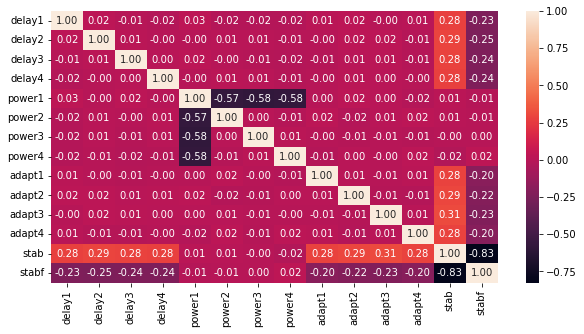

In [5]:
plt.figure(figsize = (10, 5))
sns.heatmap(stab_grid.corr(), fmt=".2f", annot=True);

The correlation between stability (stab or stabf) and delay[x] or adapt[x] columns were weak, whereas there was no obvious relationship between power[x] columns and stability.

power1 (power generated) was correlated with the other power[x] columns (power consumed), as expected, but there was no obvious correlation within delay[x] or adapt[x] columns.

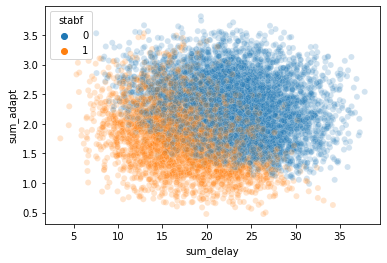

In [6]:
(stab_grid.assign(
     sum_delay = lambda x: x["delay1"] + x["delay2"] + x["delay3"] + x["delay4"],
     sum_adapt = lambda x: x["adapt1"] + x["adapt2"] + x["adapt3"] + x["adapt4"]
 )
 .pipe((sns.scatterplot, "data"), 
       x="sum_delay", y="sum_adapt", hue="stabf", alpha=0.2)
);

Together, very high or very low sums of delay[x] and adapt[x] values should be indicators of (in)stability. Without further processing, these summarised values would highly correlate with existing features, so I'd rather keep the individual features. In contrast, it might be worth removing all power[x] columns if they're unhelpful.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler, RobustScaler,
                                   FunctionTransformer, QuantileTransformer)

# model fitting / evaluation / export
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor, 
                              VotingClassifier)
from lightgbm import LGBMClassifier, LGBMRegressor, plot_metric, plot_importance
from sklearn.model_selection import (train_test_split, StratifiedKFold, KFold,
                                     cross_validate,
                                     RandomizedSearchCV, GridSearchCV)
from sklearn.metrics import (plot_confusion_matrix, classification_report,
                             plot_roc_curve)

In [9]:
X = stab_grid.drop(['stab'], axis=1)
y = stab_grid['stabf']

# split the dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

#### Question 14
What is the accuracy on the test set using the random forest classifier? In 4 decimal places.

In [26]:
from sklearn.ensemble import RandomForestClassifier
clf = clf.RandomForestClassifier()
clf.fit(X, y)

AttributeError: 'LGBMClassifier' object has no attribute 'RandomForestClassifier'

#### Question 15
What is the accuracy on the test set using the XGboost classifier? In 4 decimal places.

In [16]:
import xgboost as xgb
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
predictions = xgb_classifier.predict(X_test)
print('XGboost Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test,predictions)))
#print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

XGboost Model accuracy score: 1.0000


In [23]:
predictions_train = clf.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, predictions_train)))

Training-set accuracy score: 1.0000


#### Question 16
What is the accuracy on the test set using the LGBM classifier? In 4 decimal places.

In [18]:
# build the lightgbm model
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier()

In [19]:
# predict the results
y_pred=clf.predict(X_test)

# view accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 1.0000


In [15]:
# Now, I will compare the train-set and test-set accuracy to check for overfitting.

y_pred_train = clf.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 1.0000


# THANK YOU!